In [1]:
import deepmimo as dm
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
scen_name = 'city_0_newyork_28'
# dm.download(scen_name)
dataset = dm.load(scen_name)

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


In [10]:
dataset = dm.load('city_0_newyork_28', max_paths=4)

ch_params = dm.ChannelParameters()
ch_params.bs_antenna.shape = [8, 1]

# for v3 compatibility
ch_params.ofdm.bandwidth = 50e6
ch_params.num_paths = 4

dataset.compute_channels(ch_params)
ch_params

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


Generating channels: 100%|██████████| 31719/31719 [00:00<00:00, 53896.21it/s]


{'bs_antenna': {'radiation_pattern': 'isotropic',
 'rotation': array([0, 0, 0]),
 'shape': array([8, 1]),
 'spacing': 0.5},
 'enable_doppler': 0,
 'freq_domain': 1,
 'num_paths': 4,
 'ofdm': {'bandwidth': 50000000.0,
 'rx_filter': 0,
 'selected_subcarriers': array([0]),
 'subcarriers': 512},
 'ue_antenna': {'radiation_pattern': 'isotropic',
 'rotation': array([0, 0, 0]),
 'shape': array([1, 1]),
 'spacing': 0.5}}

In [11]:
ch_v4 = dataset.channel

print(f'v4 channels.shape = {ch_v4.shape}')

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# User sampling in v4
idxs = dataset.get_row_idxs(range(40, 50))
dataset_t = dataset.subset(idxs)
dataset_t.n_ue
dataset_t.channel.shape

AttributeError: 'list' object has no attribute 'n_ue'

In [12]:
if hasattr(dataset, 'channel') and dataset.channel is not None:
    ch_v4 = dataset.channel
    print(f'v4 channels.shape = {ch_v4.shape}')
else:
    print("Error: 'channel' attribute is not available in the dataset.")

AttributeError: 'list' object has no attribute 'shape'

In [13]:
dm.summary('city_0_newyork_28')


DeepMIMO city_0_newyork_28 Scenario Summary

[Ray-Tracing Configuration]
- Ray-tracer: Remcom Wireless Insite v3.3
- Frequency: 28.0 GHz

[Ray-tracing parameters]

Main interaction limits
- Max path depth: 4
- Max reflections: 3
- Max diffractions: 1
- Max scatterings: 1
- Max transmissions: 0

Diffuse Scattering
- Diffuse scattering: Enabled
- Diffuse reflections: 2
- Diffuse diffractions: 1
- Diffuse transmissions: 0
- Final interaction only: True
- Random phases: False

Terrain
- Terrain reflection: True
- Terrain diffraction: False
- Terrain scattering: False

Ray Casting Settings
- Number of rays: 259,200
- Casting method: uniform
- Casting range (az): 360.0°
- Casting range (el): 180.0°
- Synthetic array: True

[Scene]
- Number of scenes: 1
- Total objects: 283
- Vertices: 1,201
- Faces: 2,024
- Triangular faces: 283

[Materials]
Total materials: 3

ITU Concrete 3.5 GHz:
- Permittivity: 5.31
- Conductivity: 0.09 S/m
- Scattering model: directive
- Scattering coefficient: 0.20
- 

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


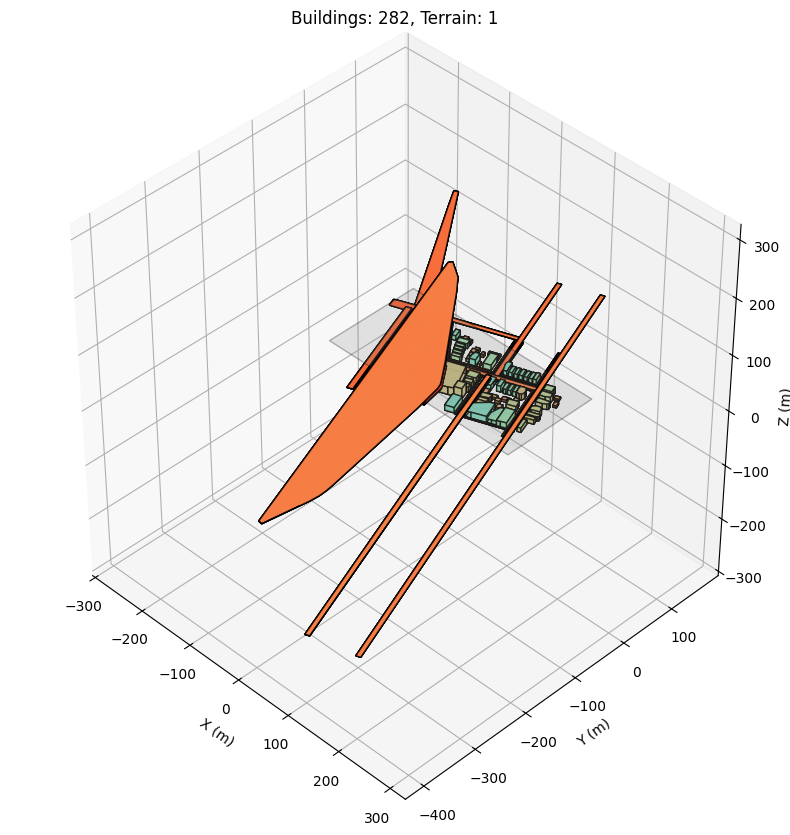

Error generating images 2: 'list' object has no attribute 'is_tx'


In [14]:
dm.plot_summary('city_0_newyork_28')

In [15]:
# ch_params = dm.ChannelParameters()  # default array has 8 elements
ch_params.bs_antenna.rotation = np.array([0, 0, -135])
# ch_params.bs_antenna.shape = np.array([32, 1])
dataset.compute_channels(ch_params)

n_beams = 16

beam_angles = np.around(np.linspace(-60, 60, n_beams), 2)
print(f'Beam angles: {beam_angles}')

# Compute Beamformers: F1 is [n_beams, n_ant]
F1 = np.array([dm.steering_vec(dataset.ch_params.bs_antenna.shape, phi=azi).squeeze()
               for azi in beam_angles])

# Apply beamformers
recv_bf_pwr_dbm = np.zeros((dataset.n_ue, n_beams)) * np.nan
mean_amplitude = np.abs(
    F1 @ dataset.channel[dataset.los != -1]).mean(axis=1).mean(axis=-1)
# Avg over rx antennas and subcarriers, respectively

# Convert to dBm
recv_bf_pwr_dbm[dataset.los != -
                1] = np.around(20*np.log10(mean_amplitude) + 30, 1)

Generating channels: 100%|██████████| 31719/31719 [00:00<00:00, 52455.07it/s]

Beam angles: [-60. -52. -44. -36. -28. -20. -12.  -4.   4.  12.  20.  28.  36.  44.
  52.  60.]


AttributeError: 'list' object has no attribute 'bs_antenna'

NameError: name 'recv_bf_pwr_dbm' is not defined

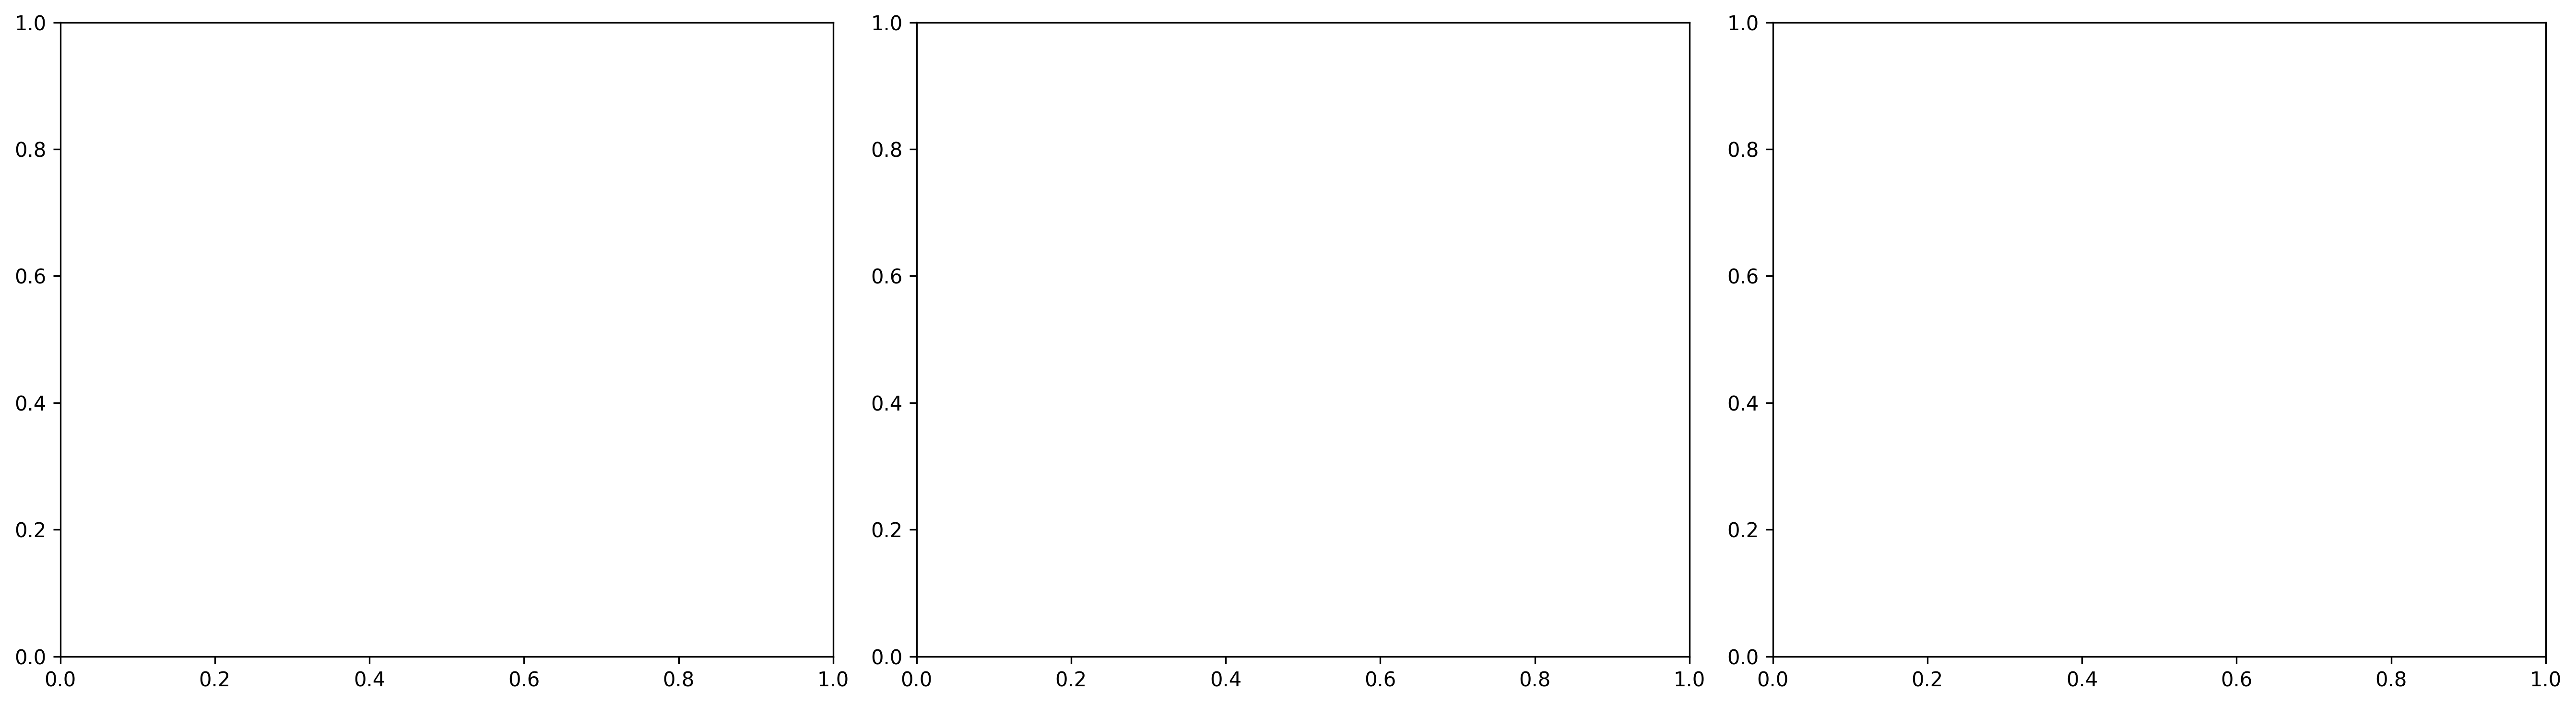

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300, tight_layout=True)

for plt_idx, beam_idx in enumerate([6, 8, 12]):
    dataset.plot_coverage(recv_bf_pwr_dbm[:, beam_idx], ax=axes[plt_idx], lims=[-180, -60],
                          title=f'Beam # {beam_idx} ({beam_angles[beam_idx]:.1f}º)')